<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA 및 방향 잡기


## MFCC를 통한 확인


In [1]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# 모듈 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
import librosa
import librosa.display

In [3]:
data = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data = data.values

In [17]:
label =pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)

In [41]:
idx = [0,2000,4000,8000,10000]
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

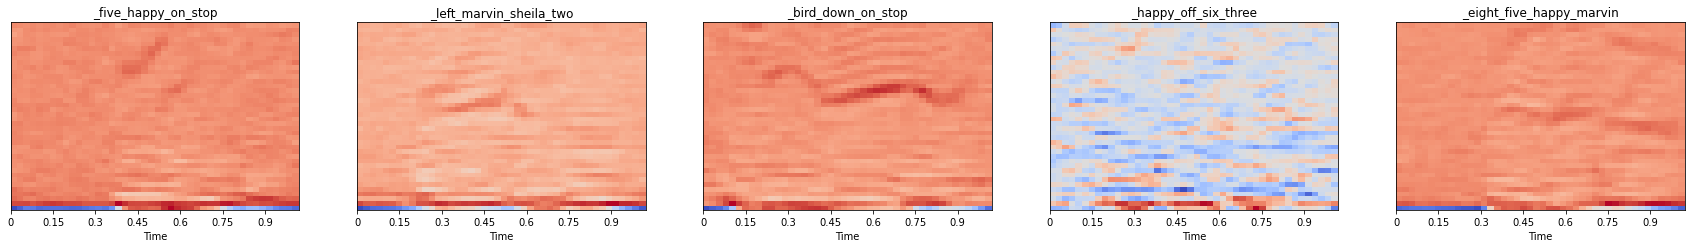

In [47]:
plt.figure(figsize=(30,20))
for i,j in enumerate(idx):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

발화하는 단어에 따라 MFCC가 확실히 구분이 간다...